<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [9]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━

##Load data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [11]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [12]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [13]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598


In [14]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [15]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [16]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [17]:
df.head()

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794


In [18]:
df.tail()

,A,B,C,D,E,F
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598


In [19]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [20]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [21]:
df.to_numpy()

array([[-0.64370799, -1.11845348, -0.84973567, -1.56425858,  0.68702279,
        -0.84308278],
       [-0.50201547, -0.50202044, -0.08012744, -0.65367011, -0.01957782,
        -0.30305547],
       [ 0.3857452 , -0.80705814,  1.72360983, -0.07159744,  1.19544723,
         0.96797193],
       [ 0.07397982,  1.11517862,  1.7748989 ,  0.25743248, -0.76488826,
         1.55043377],
       [ 1.87831514, -0.26427855,  0.04282761,  0.94222313, -0.01271636,
         0.61579442],
       [ 0.02811698, -0.06718066, -0.05961947, -0.05726038,  0.35085821,
        -0.72877628],
       [-0.16014498, -0.41369498,  0.0973328 ,  0.27264339,  0.30596162,
         0.17745269],
       [-0.51539935,  0.96697733, -1.34002818, -0.6895428 , -1.0881599 ,
         0.5485983 ]])

In [22]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [23]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.068111,-0.136316,0.163645,-0.195504,0.081743,0.248167
std,0.810968,0.795507,1.098432,0.763514,0.740081,0.836106
min,-0.643708,-1.118453,-1.340028,-1.564259,-1.088160,-0.843083
25%,-0.505361,-0.578280,-0.272529,-0.662638,-0.205905,-0.409486
50%,-0.066014,-0.338987,-0.008396,-0.064429,0.146623,0.363025
75%,0.151921,0.191359,0.503902,0.261235,0.434899,0.703839
max,1.878315,1.115179,1.774899,0.942223,1.195447,1.550434


In [24]:
df

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598


In [25]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,-0.643708,-0.502015,0.385745,0.073980,1.878315,0.028117,-0.160145,-0.515399
B,-1.118453,-0.502020,-0.807058,1.115179,-0.264279,-0.067181,-0.413695,0.966977
C,-0.849736,-0.080127,1.723610,1.774899,0.042828,-0.059619,0.097333,-1.340028
D,-1.564259,-0.653670,-0.071597,0.257432,0.942223,-0.057260,0.272643,-0.689543
E,0.687023,-0.019578,1.195447,-0.764888,-0.012716,0.350858,0.305962,-1.088160
F,-0.843083,-0.303055,0.967972,1.550434,0.615794,-0.728776,0.177453,0.548598


In [26]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,-0.843083,0.687023,-1.564259,-0.849736,-1.118453,-0.643708
2023-01-02,-0.303055,-0.019578,-0.653670,-0.080127,-0.502020,-0.502015
2023-01-03,0.967972,1.195447,-0.071597,1.723610,-0.807058,0.385745
2023-01-04,1.550434,-0.764888,0.257432,1.774899,1.115179,0.073980
2023-01-05,0.615794,-0.012716,0.942223,0.042828,-0.264279,1.878315
2023-01-06,-0.728776,0.350858,-0.057260,-0.059619,-0.067181,0.028117
2023-01-07,0.177453,0.305962,0.272643,0.097333,-0.413695,-0.160145
2023-01-08,0.548598,-1.088160,-0.689543,-1.340028,0.966977,-0.515399


In [27]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434


In [28]:
df

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598


##Getting

In [29]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01   -0.643708
2023-01-02   -0.502015
2023-01-03    0.385745
2023-01-04    0.073980
2023-01-05    1.878315
2023-01-06    0.028117
2023-01-07   -0.160145
2023-01-08   -0.515399
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [30]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972


In [31]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434


In [32]:
df

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598


##Selection by label

In [33]:
df.loc[dates[1]]

A   -0.502015
B   -0.502020
C   -0.080127
D   -0.653670
E   -0.019578
F   -0.303055
Name: 2023-01-02 00:00:00, dtype: float64

In [34]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,-0.643708,-1.564259
2023-01-02,-0.502015,-0.653670
2023-01-03,0.385745,-0.071597
2023-01-04,0.073980,0.257432
2023-01-05,1.878315,0.942223
2023-01-06,0.028117,-0.057260
2023-01-07,-0.160145,0.272643
2023-01-08,-0.515399,-0.689543


In [35]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,0.073980,0.257432
2023-01-05,1.878315,0.942223
2023-01-06,0.028117,-0.057260


In [36]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A    0.073980
D    0.257432
Name: 2023-01-04 00:00:00, dtype: float64

In [37]:
# For getting a scalar value
df.loc[dates[1], "D"]

-0.6536701140832242

In [38]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

-0.6536701140832242

##Selection by position

In [39]:
df.iloc[3]

A    0.073980
B    1.115179
C    1.774899
D    0.257432
E   -0.764888
F    1.550434
Name: 2023-01-04 00:00:00, dtype: float64

In [40]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,0.073980,1.115179
2023-01-05,1.878315,-0.264279


In [41]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-0.502015,-0.080127
2023-01-03,0.385745,1.723610
2023-01-05,1.878315,0.042828


In [42]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972


In [43]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,-1.118453,-0.849736
2023-01-02,-0.502020,-0.080127
2023-01-03,-0.807058,1.723610
2023-01-04,1.115179,1.774899
2023-01-05,-0.264279,0.042828
2023-01-06,-0.067181,-0.059619
2023-01-07,-0.413695,0.097333
2023-01-08,0.966977,-1.340028


In [44]:
# For getting values explicitly
df.iloc[1, 1]

-0.502020436790043

In [45]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

-0.502020436790043

## Boolean indexing
Using a single column's values to select data:

In [46]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776


In [47]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,NaN,NaN,NaN,NaN,0.687023,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,0.385745,NaN,1.723610,NaN,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,NaN,1.550434
2023-01-05,1.878315,NaN,0.042828,0.942223,NaN,0.615794
2023-01-06,0.028117,NaN,NaN,NaN,0.350858,NaN
2023-01-07,NaN,NaN,0.097333,0.272643,0.305962,0.177453
2023-01-08,NaN,0.966977,NaN,NaN,NaN,0.548598


In [48]:
df

,A,B,C,D,E,F
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598


In [49]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,-0.643708,-1.118453,-0.849736,-1.564259,0.687023,-0.843083,one
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055,one
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972,two
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434,three
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794,four
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776,three
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453,five
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598,four


In [50]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972,two
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794,four
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [51]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [52]:
df["G"] = s1

In [53]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [54]:
# Setting values by position:
df.iat[0, 1] = 0

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,0.687023,-0.843083,NaN
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-0.019578,-0.303055,1.0
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,1.195447,0.967972,2.0
2023-01-04,0.073980,1.115179,1.774899,0.257432,-0.764888,1.550434,3.0
2023-01-05,1.878315,-0.264279,0.042828,0.942223,-0.012716,0.615794,4.0
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,0.350858,-0.728776,5.0
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,0.305962,0.177453,6.0
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,-1.088160,0.548598,NaN


In [56]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [57]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,5,-0.843083,NaN
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,5,-0.303055,1.0
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,5,0.967972,2.0
2023-01-04,0.073980,1.115179,1.774899,0.257432,5,1.550434,3.0
2023-01-05,1.878315,-0.264279,0.042828,0.942223,5,0.615794,4.0
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,5,-0.728776,5.0
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,5,0.177453,6.0
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,5,0.548598,NaN


In [58]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,-5,-0.843083,NaN
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,-5,-0.303055,-1.0
2023-01-03,-0.385745,-0.807058,-1.723610,-0.071597,-5,-0.967972,-2.0
2023-01-04,-0.073980,-1.115179,-1.774899,-0.257432,-5,-1.550434,-3.0
2023-01-05,-1.878315,-0.264279,-0.042828,-0.942223,-5,-0.615794,-4.0
2023-01-06,-0.028117,-0.067181,-0.059619,-0.057260,-5,-0.728776,-5.0
2023-01-07,-0.160145,-0.413695,-0.097333,-0.272643,-5,-0.177453,-6.0
2023-01-08,-0.515399,-0.966977,-1.340028,-0.689543,-5,-0.548598,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [59]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,5,-0.843083,1.0,1.0
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,5,-0.303055,1.0,1.0
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,5,0.967972,2.0,2.0
2023-01-04,0.073980,1.115179,1.774899,0.257432,5,1.550434,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [60]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,5,-0.843083,1.0,1.0
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,5,-0.303055,1.0,1.0
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,5,0.967972,2.0,2.0
2023-01-04,0.073980,1.115179,1.774899,0.257432,5,1.550434,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [61]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,5,-0.843083,1.0,1.0
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,5,-0.303055,1.0,1.0
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,5,0.967972,2.0,2.0
2023-01-04,0.073980,1.115179,1.774899,0.257432,5,1.550434,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [62]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [63]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,5,-0.843083,NaN
2023-01-02,-0.502015,-0.502020,-0.080127,-0.653670,5,-0.303055,1.0
2023-01-03,0.385745,-0.807058,1.723610,-0.071597,5,0.967972,2.0
2023-01-04,0.073980,1.115179,1.774899,0.257432,5,1.550434,3.0
2023-01-05,1.878315,-0.264279,0.042828,0.942223,5,0.615794,4.0
2023-01-06,0.028117,-0.067181,-0.059619,-0.057260,5,-0.728776,5.0
2023-01-07,-0.160145,-0.413695,0.097333,0.272643,5,0.177453,6.0
2023-01-08,-0.515399,0.966977,-1.340028,-0.689543,5,0.548598,NaN


In [64]:
df.mean()

A    0.148575
B    0.003490
C    0.163645
D   -0.195504
E    5.000000
F    0.248167
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [65]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [66]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.614255,-1.807058,0.723610,-1.071597,4.0,-0.032028,1.0
2023-01-04,-2.926020,-1.884821,-1.225101,-2.742568,2.0,-1.449566,0.0
2023-01-05,-2.121685,-4.264279,-3.957172,-3.057777,1.0,-3.384206,0.0
2023-01-06,-4.971883,-5.067181,-5.059619,-5.057260,0.0,-5.728776,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-6.515399,-5.033023,-7.340028,-6.689543,-1.0,-5.451402,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [67]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.849736,-1.564259,5,-0.843083,NaN
2023-01-02,-0.502015,-0.502020,-0.929863,-2.217929,10,-1.146138,1.0
2023-01-03,-0.116270,-1.309079,0.793747,-2.289526,15,-0.178166,3.0
2023-01-04,-0.042290,-0.193900,2.568646,-2.032094,20,1.372267,6.0
2023-01-05,1.836025,-0.458179,2.611473,-1.089871,25,1.988062,10.0
2023-01-06,1.864142,-0.525359,2.551854,-1.147131,30,1.259286,15.0
2023-01-07,1.703997,-0.939054,2.649187,-0.874488,35,1.436738,21.0
2023-01-08,1.188597,0.027923,1.309158,-1.564030,40,1.985337,NaN


In [68]:
df.apply(lambda x: x.max() - x.min())

A    2.393714
B    1.922237
C    3.114927
D    2.506482
E    0.000000
F    2.393517
G    5.000000
dtype: float64

##Histogramming

In [69]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    2
1    1
2    4
3    4
4    1
5    2
6    3
7    5
8    5
9    4
dtype: int64

In [70]:
s.value_counts()

4    3
2    2
1    2
5    2
3    1
dtype: int64

##String Methods


In [74]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [75]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,1.369701,-0.464617,-0.501562,-1.148588
1,-0.646763,-0.030267,1.013653,1.245551
2,-0.114007,0.852801,1.389355,2.417193
3,0.988119,-0.198800,-0.233460,0.095823
4,-0.023924,-1.165004,-1.294548,0.146342
5,-0.510715,-0.832322,-1.960847,0.122088
6,0.392200,0.068592,1.173581,0.302726
7,-2.372343,-0.443160,0.863499,0.353406
8,0.279244,1.876013,-1.227579,-1.030906
9,-2.318521,0.266247,1.756201,-0.702562


In [76]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,1.369701,-0.464617,-0.501562,-1.148588
1,-0.646763,-0.030267,1.013653,1.245551
2,-0.114007,0.852801,1.389355,2.417193
3,0.988119,-0.198800,-0.233460,0.095823
4,-0.023924,-1.165004,-1.294548,0.146342
5,-0.510715,-0.832322,-1.960847,0.122088
6,0.392200,0.068592,1.173581,0.302726
7,-2.372343,-0.443160,0.863499,0.353406
8,0.279244,1.876013,-1.227579,-1.030906
9,-2.318521,0.266247,1.756201,-0.702562


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [77]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [78]:
right

,key,rval
0,foo,4
1,foo,5


In [79]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [82]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [83]:
right

,key,rval
0,foo,4
1,bar,5


In [85]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [86]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,-0.200010,0.890263
1,bar,one,-0.710946,0.830556
2,foo,two,-1.083974,0.419816
3,bar,three,0.658116,0.409524
4,foo,two,0.673820,1.269275
5,bar,two,0.115954,2.150680
6,foo,one,-0.112965,0.839788
7,foo,three,0.981421,1.851734


Grouping and then applying the `sum()` function to the resulting groups:

In [87]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,0.063124,3.390760
foo,0.258291,5.270875


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [88]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -0.710946  0.830556
    three  0.658116  0.409524
    two    0.115954  2.150680
foo one   -0.312975  1.730051
    three  0.981421  1.851734
    two   -0.410154  1.689091

##Reshaping
**Stack**

In [92]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.365749 -1.233557
      two    -0.853983  0.690381
baz   one     0.607901  0.281281
      two    -0.027623 -1.379972

The `stack()` method "compresses" a level in the DataFrame's columns:

In [93]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.365749
               B   -1.233557
       two     A   -0.853983
               B    0.690381
baz    one     A    0.607901
               B    0.281281
       two     A   -0.027623
               B   -1.379972
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [94]:
stacked.unstack()

A         B
first second                    
bar   one    -0.365749 -1.233557
      two    -0.853983  0.690381
baz   one     0.607901  0.281281
      two    -0.027623 -1.379972

In [95]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.365749 -0.853983
      B -1.233557  0.690381
baz   A  0.607901 -0.027623
      B  0.281281 -1.379972

In [96]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.365749  0.607901
       B -1.233557  0.281281
two    A -0.853983 -0.027623
       B  0.690381 -1.379972

##Pivot tables

In [101]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,1.417397,-0.490375
1,one,B,foo,-1.007944,-0.080807
2,two,C,foo,0.398620,-0.877550
3,three,A,bar,1.760892,-0.653464
4,one,B,bar,-0.058600,-0.373418
5,one,C,bar,1.968430,1.459246
6,two,A,foo,-0.489510,0.736081
7,three,B,foo,-1.008583,0.482365
8,one,C,foo,-0.252949,-0.101989
9,one,A,bar,0.508326,-1.746701


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [102]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A  0.508326  1.417397
      B -0.058600 -1.007944
      C  1.968430 -0.252949
three A  1.760892       NaN
      B       NaN -1.008583
      C -0.873013       NaN
two   A       NaN -0.489510
      B  1.278358       NaN
      C       NaN  0.398620

##Time series

In [103]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24898
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [104]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06    0.693521
2012-03-07    0.133402
2012-03-08    1.181540
2012-03-09   -0.555456
2012-03-10    0.481931
Freq: D, dtype: float64

In [105]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00    0.693521
2012-03-07 00:00:00+00:00    0.133402
2012-03-08 00:00:00+00:00    1.181540
2012-03-09 00:00:00+00:00   -0.555456
2012-03-10 00:00:00+00:00    0.481931
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [106]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00    0.693521
2012-03-06 19:00:00-05:00    0.133402
2012-03-07 19:00:00-05:00    1.181540
2012-03-08 19:00:00-05:00   -0.555456
2012-03-09 19:00:00-05:00    0.481931
Freq: D, dtype: float64

Converting between time span representations:

In [107]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    1.175991
2012-02-29   -0.012876
2012-03-31    2.217962
2012-04-30    0.950330
2012-05-31    1.354566
Freq: M, dtype: float64

In [108]:
ps = ts.to_period()

ps 

2012-01    1.175991
2012-02   -0.012876
2012-03    2.217962
2012-04    0.950330
2012-05    1.354566
Freq: M, dtype: float64

In [113]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    1.175991
2012-02-01   -0.012876
2012-03-01    2.217962
2012-04-01    0.950330
2012-05-01    1.354566
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [115]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -0.597847
1990-06-01 09:00   -0.264180
1990-09-01 09:00    1.610184
1990-12-01 09:00    0.618939
1991-03-01 09:00    1.304809
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [116]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [117]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [118]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [119]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [120]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [121]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [122]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

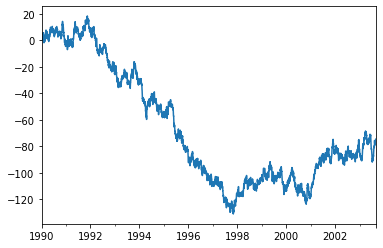

In [127]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [129]:
plt.show();

<Figure size 432x288 with 0 Axes>

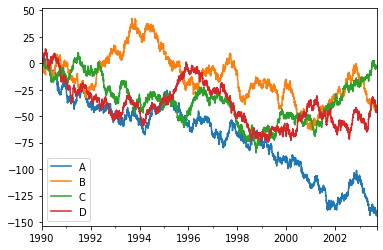

In [132]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [133]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [134]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,-1.173198,-0.038443,0.881123,2.275472
1,1990-01-02,-1.131910,0.417778,0.485649,1.926135
2,1990-01-03,-0.668719,-0.165267,1.076336,1.624735
3,1990-01-04,-1.895209,0.227378,1.839872,2.327366
4,1990-01-05,-2.854202,-0.145794,1.502891,2.440989
...,...,...,...,...,...
4995,2003-09-05,-143.265681,-39.900592,-4.725596,-46.623025
4996,2003-09-06,-143.460364,-41.042086,-3.677980,-45.087292
4997,2003-09-07,-144.186624,-39.777472,-3.822710,-45.349528
4998,2003-09-08,-143.006764,-39.250099,-3.568066,-45.507748


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [135]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [137]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,-1.173198,-0.038443,0.881123,2.275472
1990-01-02,-1.131910,0.417778,0.485649,1.926135
1990-01-03,-0.668719,-0.165267,1.076336,1.624735
1990-01-04,-1.895209,0.227378,1.839872,2.327366
1990-01-05,-2.854202,-0.145794,1.502891,2.440989
...,...,...,...,...
2003-09-05,-143.265681,-39.900592,-4.725596,-46.623025
2003-09-06,-143.460364,-41.042086,-3.677980,-45.087292
2003-09-07,-144.186624,-39.777472,-3.822710,-45.349528
2003-09-08,-143.006764,-39.250099,-3.568066,-45.507748
